# Project 2 - Classifying data from the MAGIC Gamma Ray Telescope data with Machine Learning (Decision Tree Learning)


## Introduction

Note: This project is a follow up to "Project 1 - Classifying MAGIC data by hand"

We will again access data from the MAGIC telescope and anayze it in order to better classify observed particles as being either gamma rays (signal) or neutrons (background). In Project 2 we will utilize Machine Learning to improve our classification.
   
MAGIC data is currently hosted at the [UC Irvine Machine Learning Repository](https://archive.ics.uci.fAsymedu/ml/datasets/MAGIC+Gamma+Telescope).
  
The repository also contains a description of data and variables [here](https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names). For more information please read:
1. [Bock, R.k., et al. "Methods for multidimensional event classification: a case study using images from
a Cherenkov gamma-ray telescope"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.135.6914&rep=rep1&type=pdf)
2. [Fegan, D. "Gamma/Hadron seperation at TeV Energies"](http://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf)

As defined in the references above, the important variables which will be used to classify shower images are based on the characteristics of a typical elliptical shower shape:


    1. fLength:  continuous  # major axis of ellipse [mm]
    2. fWidth:   continuous  # minor axis of ellipse [mm]
    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm]
    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
    10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
    11.  class:    g,h         # gamma (signal), hadron (background)


<img src="https://github.com/jdolen/PurdueNorthwest_PHYS308_ScientificComputing1/raw/master/Images/MAGIClight.jpg" alt="Drawing" style="width: 600px;"/>

<img src="https://raw.githubusercontent.com/jdolen/PurdueNorthwest_PHYS308_ScientificComputing1/master/Images/MAGICshowerShape.png" alt="Drawing"  width="600"/>

The simulated data provided has already been classified (we have the truth information). This will allow us to test how succesful we are at classifying the data using only the shower shape variables. The data is labeled using the following classifications:

   - g = gamma (signal):     12332 events
   - h = hadron (background): 6688 events


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from scipy import stats, integrate

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics

In [3]:
# If you are using Google Colab the following imports should just work
# If you are using Jupyter on your home computer you will have to install some fancy tools to visualize your BDT
# To install with conda, from your terminal run:
#  conda install -c conda-forge mlxtend
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [4]:
# Data from MAGIC Gamma Ray Telescope
#   (Major Atmospheric Gamma Imaging Cherenkov Telescopes)
#
# Data hosted by UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/index.php):
#  https://archive.ics.uci.fAsymedu/ml/datasets/MAGIC+Gamma+Telescope
#
# Infromation on data and variables:
#  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
#
# Paper with some details on the data
#  http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.135.6914&rep=rep1&type=pdf
#
# Paper describing variable definitions in more detail:
#  http://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf
#
# Important variables:
#    1.  fLength:  continuous  # major axis of ellipse [mm]
#    2.  fWidth:   continuous  # minor axis of ellipse [mm]
#    3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
#    4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
#    5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
#    6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
#    7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm]
#    8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
#    9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
#   10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
#   11.  class:    g,h         # gamma (signal), hadron (background)

# Class Distribution:
#
#   g = gamma (signal):     12332
#   h = hadron (background): 6688


# Read-in data

data_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data'

# Backup: data_path = 'https://raw.githubusercontent.com/jdolen/PurdueNorthwest_PHYS308_ScientificComputing1/master/Data/magic04.data'

variable_names =['fLength',   'fWidth',  'fSize', 'fConc','fConc1', 'fAsym',
                 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv(data_path, names=variable_names, na_values='?')

# Add a gamma boolean column
df.loc[df['class'] == 'g', 'isGamma'] = True
df.loc[df['class'] == 'h', 'isGamma'] = False

# Add a hadron boolean column
df.loc[df['class'] == 'h', 'isHadron'] = True
df.loc[df['class'] == 'g', 'isHadron'] = False

# Create a new data frame with just gammas (this is our signal)
df_gammas  = df[df['isGamma'] == True]

# Create a new data frame with just hadrons (this is our background)
df_hadrons = df[df['isHadron'] == True]

# Divide up the data into training and testing datasets
df_gammas_train  = df_gammas.iloc[0:2000]
df_gammas_test   = df_gammas.iloc[2000:]
df_hadrons_train = df_hadrons.iloc[0:2000]
df_hadrons_test  = df_hadrons.iloc[2000:]

# Define also a small sub-sample of the testing dataset for plotting purposes
df_gammas_test_small   = df_gammas.iloc[2000:2400]
df_hadrons_test_small  = df_hadrons.iloc[2000:2400]

# Put the training datasets back together (combine signal and background)
df_all_train      = pd.concat([df_gammas_train , df_hadrons_train] ,axis=0 )
df_all_test       = pd.concat([df_gammas_test  , df_hadrons_test]  ,axis=0 )
df_all_test_small = pd.concat([df_gammas_test_small,df_hadrons_test_small],axis=0)

# Define the "isGamma" column to be the column which is used to define signal events and background events
df_all_train["isGamma"]      = df_all_train["isGamma"].astype('category')
df_all_test["isGamma"]       = df_all_test["isGamma"].astype('category')
df_all_test_small["isGamma"] = df_all_test_small["isGamma"].astype('category')

In [5]:
# Take a quick look at the testing dataset
df_all_test[-5:]

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,isGamma,isHadron
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h,False,True
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h,False,True
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h,False,True
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h,False,True
19019,187.1814,53.0014,3.2093,0.2876,0.1539,-167.3125,-168.4558,31.4755,52.7310,272.3174,h,False,True


## Example: Create a 2 feature Decision Tree with Scikit-Learn

This section contains an example of creating a decision trees using Skikit-Learn. We will first use only two features from our dataset (fAlpha and fLength). We will grow both a depth=1 and a depth=2 tree.

#### Training setup

In [6]:
# Create a pandas series for each of the two variables
series_train_fLength        = df_all_train['fLength']
series_train_fAlpha         = df_all_train['fAlpha']

# Create a pandas dataframe containing just these two variables
df_train_fLength_fAlpha = pd.DataFrame(dict(fLength=series_train_fLength, fAlpha=series_train_fAlpha))

# Create a 2D numpy array from this dataframe
X_train_fLength_fAlpha  = df_train_fLength_fAlpha .to_numpy(dtype='float')

# Create a 1D numpy array containing the "truth" information
y_train = df_all_train["isGamma"].cat.codes.to_numpy(dtype='int')

In [7]:
# Take a quick look at our dataframe
df_train_fLength_fAlpha

,fLength,fAlpha
0,28.7967,40.0920
1,31.6036,6.3609
2,162.0520,76.9600
3,23.8172,10.4490
4,75.1362,4.6480
...,...,...
14327,33.8510,85.1914
14328,132.8950,33.8380
14329,217.8370,42.6820
14330,19.7752,74.0078


In [8]:
# Take a quick look at our training array.
#  fLength is in column 0
#  fAlpha is in column 1
#  Each row is an different event
X_train_fLength_fAlpha

array([[ 28.7967,  40.092 ],
       [ 31.6036,   6.3609],
       [162.052 ,  76.96  ],
       ...,
       [217.837 ,  42.682 ],
       [ 19.7752,  74.0078],
       [ 16.0175,  81.0796]])

In [9]:
# Our truth array contains 1 for signal gammas and 0 for background hadrons
#   (each entry is a different event)
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
# A bit of extra explanation: How did we generate y_train?
#   Our series hase two categories (False, True)
df_all_train["isGamma"]

0         True
1         True
2         True
3         True
4         True
         ...  
14327    False
14328    False
14329    False
14330    False
14331    False
Name: isGamma, Length: 4000, dtype: category
Categories (2, bool): [False, True]

In [11]:
# A bit of extra explanation: How did we generate y_train?
# pandas.Series.cat returns categorical properties
# https://pandas.pydata.org/docs/reference/api/pandas.Series.cat.html
print(type(df_all_train["isGamma"].cat))
df_all_train["isGamma"].cat

<class 'pandas.core.arrays.categorical.CategoricalAccessor'>


In [12]:
# A bit of extra explanation: How did we generate y_train?
# Codes are numbers assigned to each category
print(type(df_all_train["isGamma"].cat.codes))
print("Category 0 = ",df_all_train["isGamma"].cat.categories[0])
print("Category 1 = ",df_all_train["isGamma"].cat.categories[1])
print("All codes:")
df_all_train["isGamma"].cat.codes

<class 'pandas.core.series.Series'>
Category 0 =  False
Category 1 =  True
All codes:


0        1
1        1
2        1
3        1
4        1
        ..
14327    0
14328    0
14329    0
14330    0
14331    0
Length: 4000, dtype: int8

In [13]:
# A bit of extra explanation: How did we generate y_train?
# pandas.DataFame.to_numpy creates a numpy array from this series
print(type(df_all_train["isGamma"].cat.codes.to_numpy(dtype='int8')))
df_all_train["isGamma"].cat.codes.to_numpy(dtype='int8')

<class 'numpy.ndarray'>


array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

### Testing setup

In [14]:
# Repeat this process using the testing datasets

# Create a pandas series for each of the two variables
series_test_fAlpha          = df_all_test['fAlpha']
series_test_fLength         = df_all_test['fLength']
series_test_small_fAlpha    = df_all_test_small['fAlpha']
series_test_small_fLength   = df_all_test_small['fLength']

# Create a pandas dataframe containing just these two variables
df_test_fLength_fAlpha       = pd.DataFrame(dict(fLength=series_test_fLength, fALpha=series_test_fAlpha))
df_test_fLength_fAlpha_small = pd.DataFrame(dict(fLength=series_test_small_fLength, fALpha=series_test_small_fAlpha))

# Create a 2D numpy array from this dataframe
X_test_fLength_fAlpha       = df_test_fLength_fAlpha.to_numpy(dtype='float')
X_test_fLength_fAlpha_small = df_test_fLength_fAlpha_small.to_numpy(dtype='float')

# Create a 1D numpy array containing the "truth" information for this testing dataset
y_test = df_all_test["isGamma"].cat.codes.to_numpy(dtype='int8')
y_test_small = df_all_test_small["isGamma"].cat.codes.to_numpy(dtype='int8')


### Cross checks

Lets just play around for a minute to make sure that we understand how to access features in signal and background using our arrays.

In [15]:
# Plot our numpy arrays for signal and background (just to check that everything looks okay)

# X_test_fAlpha_fLength is a 2D array with fLength in column 0 and fAlpha in column 1
# Check that we can access individual feature information (Create 1D arrays)
all_train_fLength = X_train_fLength_fAlpha[:,0]
all_train_fAlpha  = X_train_fLength_fAlpha[:,1]

# Get the truth information and create arrays just for signal events
y_train_bool = np.array(y_train, dtype=bool)
sig_train_fLength = all_train_fLength[y_train_bool]
sig_train_fAlpha  = all_train_fAlpha[y_train_bool]

# Get the truth information and create arrays just for background events
y_train_inverse_bool = np.invert(y_train_bool)
bkg_train_fLength  = all_train_fLength[y_train_inverse_bool]
bkg_train_fAlpha   = all_train_fAlpha[y_train_inverse_bool]

print("len(all)",len(all_train_fLength) )
print("len(y_train_bool)",len(y_train_bool) )
print("len(sig)",len(sig_train_fLength) )
print("len(bkg)",len(bkg_train_fLength) )
print("len(sig+bkg)",len(sig_train_fLength)+len(bkg_train_fLength) )

len(all) 4000
len(y_train_bool) 4000
len(sig) 2000
len(bkg) 2000
len(sig+bkg) 4000


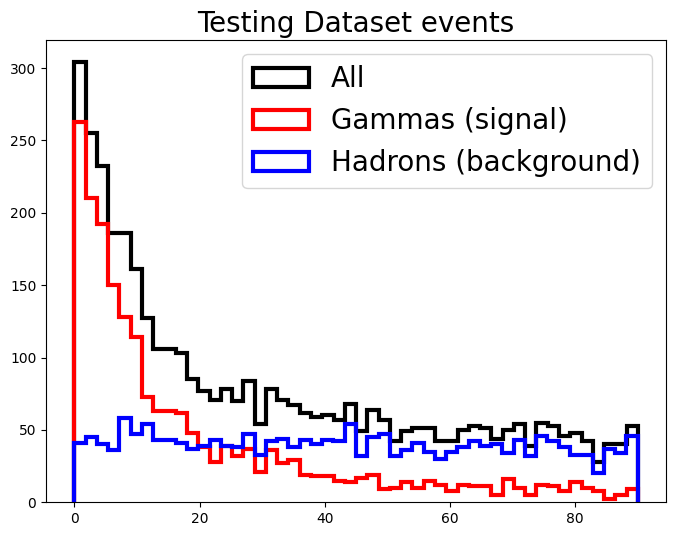

In [16]:
# Plot a histogram from the arrays

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n_bins = 50
ax.hist(all_train_fAlpha, bins=n_bins, histtype='step', lw=3, color = "black", label="All" )
ax.hist(sig_train_fAlpha, bins=n_bins, histtype='step', lw=3, color = "red", label="Gammas (signal)" )
ax.hist(bkg_train_fAlpha, bins=n_bins, histtype='step', lw=3, color = "blue", label="Hadrons (background)" )
ax.set_title('Testing Dataset events',  fontsize=20)

ax.legend(loc='upper right', prop={'size': 20})

### Create and fit the decision tree classifier (Depth 1 and 2)

Here we will use the python package scikit-learn to "grow the tree. We will use the DecisionTreeClassifier class to create our classifier (clf) with a fixed max_depth (we will fix the number of splittings). We will then use DecisionTreeClassifier.fit() method to build the tree (we will grow the tree).

[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

max_depth = The maximum depth of the tree

In [17]:
# Create the classifiers (clf). d1->max_depth=1. d2->max_depth=2.
tree_clf_d1 = DecisionTreeClassifier(max_depth=1)
tree_clf_d2 = DecisionTreeClassifier(max_depth=2)

# Build the classifiers using the training dataset and truth information
tree_clf_d1.fit(X_train_fLength_fAlpha, y_train)
tree_clf_d2.fit(X_train_fLength_fAlpha, y_train)

DecisionTreeClassifier(max_depth=2)

### Get the outputs of the classifiers

Now that we have grown the tree, we can feed all of the testing data to the tree. The DecisionTreeClassifier.predict() method will return the classification label for each event in the testing data. The predict_proba() method returns for each leaf A: $P=n_A/(n_A+n_B)$.



In [18]:
# Get the BDT predictions for your test dataset
tree_clf_d1_pred = tree_clf_d1.predict(X_test_fLength_fAlpha)
tree_clf_d2_pred = tree_clf_d2.predict(X_test_fLength_fAlpha)

# Get the BDT prediction probabilities from your test dataset
#   (the fraction of samples in each leaf)
tree_clf_d1_proba = tree_clf_d1.predict_proba(X_test_fLength_fAlpha)[:,1]
tree_clf_d2_proba = tree_clf_d2.predict_proba(X_test_fLength_fAlpha)[:,1]

In [19]:
# View predictions (1=true=signal)
tree_clf_d2_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
# View truth
y_test[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [21]:
# View probabilities (Fraction of samples in each leaf)
tree_clf_d2_proba

array([0.79223072, 0.46371977, 0.79223072, ..., 0.06229508, 0.06229508,
       0.06229508])

In [22]:
tree_clf_d1.predict_proba(X_test_fLength_fAlpha)

array([[0.26458112, 0.73541888],
       [0.71002838, 0.28997162],
       [0.26458112, 0.73541888],
       ...,
       [0.71002838, 0.28997162],
       [0.71002838, 0.28997162],
       [0.71002838, 0.28997162]])

In [23]:
tree_clf_d2.predict_proba(X_test_fLength_fAlpha)

array([[0.20776928, 0.79223072],
       [0.53628023, 0.46371977],
       [0.20776928, 0.79223072],
       ...,
       [0.93770492, 0.06229508],
       [0.93770492, 0.06229508],
       [0.93770492, 0.06229508]])

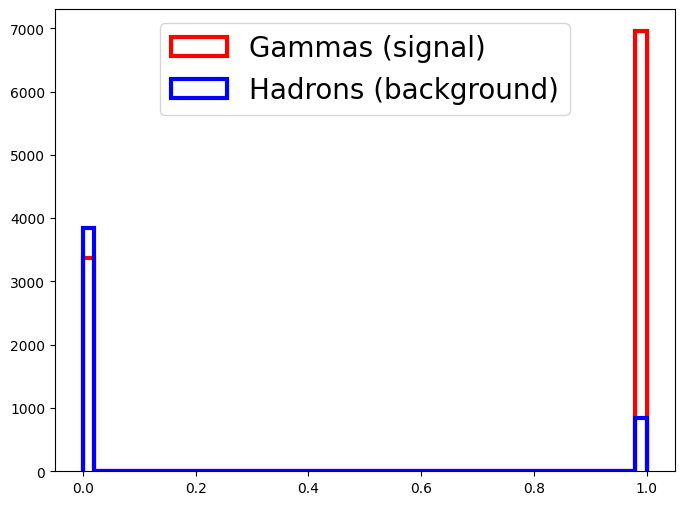

In [24]:
# Plot the Predictions - Depth = 2

# Get the truth information and create arrays just for signal events
y_test_bool = np.array(y_test, dtype=bool)
sig_tree_clf_d2_pred = tree_clf_d2_pred[y_test_bool]

# Get the truth information and create arrays just for background events
y_test_inverse_bool = np.invert(y_test_bool)
bkg_tree_clf_d2_pred = tree_clf_d2_pred[y_test_inverse_bool]

# Plot histogram

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n_bins = 50
ax.hist(sig_tree_clf_d2_pred, bins=n_bins, histtype='step', lw=3, color = "red", label="Gammas (signal)" )
ax.hist(bkg_tree_clf_d2_pred, bins=n_bins, histtype='step', lw=3, color = "blue", label="Hadrons (background)" )

ax.legend(loc='upper center', prop={'size': 20})

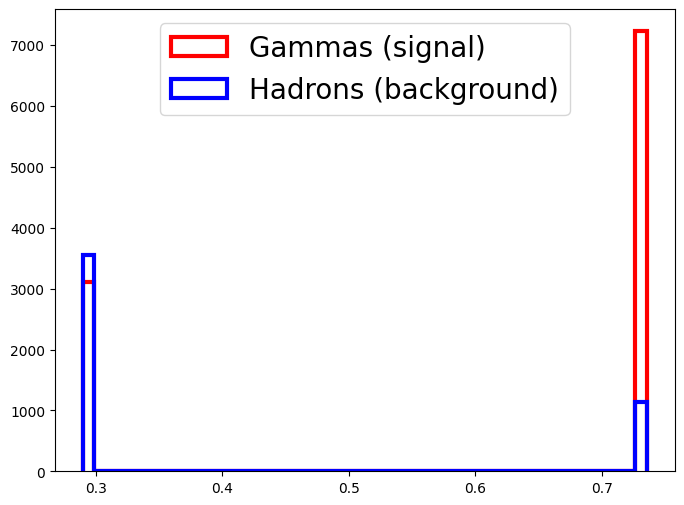

In [25]:
# Plot the probabilities - Depth = 1

# Get the truth information and create arrahs just for signal events
y_test_bool = np.array(y_test, dtype=bool)
sig_tree_clf_d1_proba = tree_clf_d1_proba[y_test_bool]

# Get the truth information and create arrahs just for background events
y_test_inverse_bool = np.invert(y_test_bool)
bkg_tree_clf_d1_proba = tree_clf_d1_proba[y_test_inverse_bool]

# Plot histogram

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n_bins = 50
ax.hist(sig_tree_clf_d1_proba, bins=n_bins, histtype='step', lw=3, color = "red", label="Gammas (signal)" )
ax.hist(bkg_tree_clf_d1_proba, bins=n_bins, histtype='step', lw=3, color = "blue", label="Hadrons (background)" )

ax.legend(loc='upper center', prop={'size': 20})

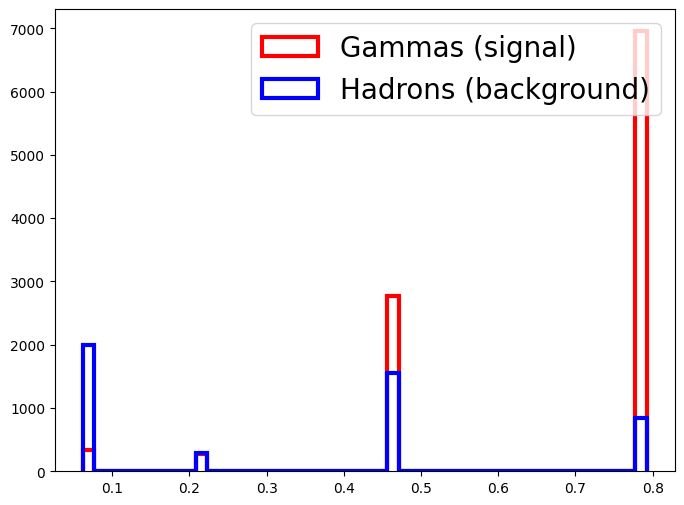

In [26]:
# Plot the probabilities - Depth = 2

# Get the truth information and create arrahs just for signal events
y_test_bool = np.array(y_test, dtype=bool)
sig_tree_clf_d2_proba = tree_clf_d2_proba[y_test_bool]

# Get the truth information and create arrahs just for background events
y_test_inverse_bool = np.invert(y_test_bool)
bkg_tree_clf_d2_proba = tree_clf_d2_proba[y_test_inverse_bool]

# Plot histogram

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

n_bins = 50
ax.hist(sig_tree_clf_d2_proba, bins=n_bins, histtype='step', lw=3, color = "red", label="Gammas (signal)" )
ax.hist(bkg_tree_clf_d2_proba, bins=n_bins, histtype='step', lw=3, color = "blue", label="Hadrons (background)" )

ax.legend(loc='upper right', prop={'size': 20})

### Visualize the output

Here we will discuss three methods to view the tree we grew.

#### Scatter Plots with Decision Regions

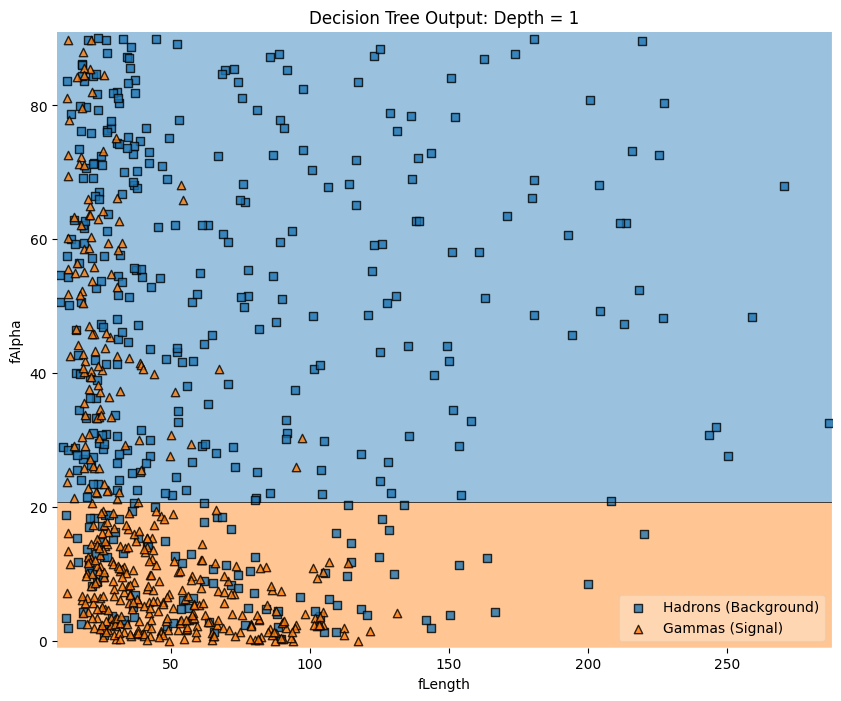

In [27]:
# View our 2 feature depth=1 tree by displaying both
#  our decision regions and a scatter plot of our small test dataset
#  in a 2D plot
fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=tree_clf_d1, legend=0)
plt.title('Decision Tree Output: Depth = 1')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ['Hadrons (Background)', 'Gammas (Signal)'],
           framealpha=0.3, scatterpoints=1)
plt.show()

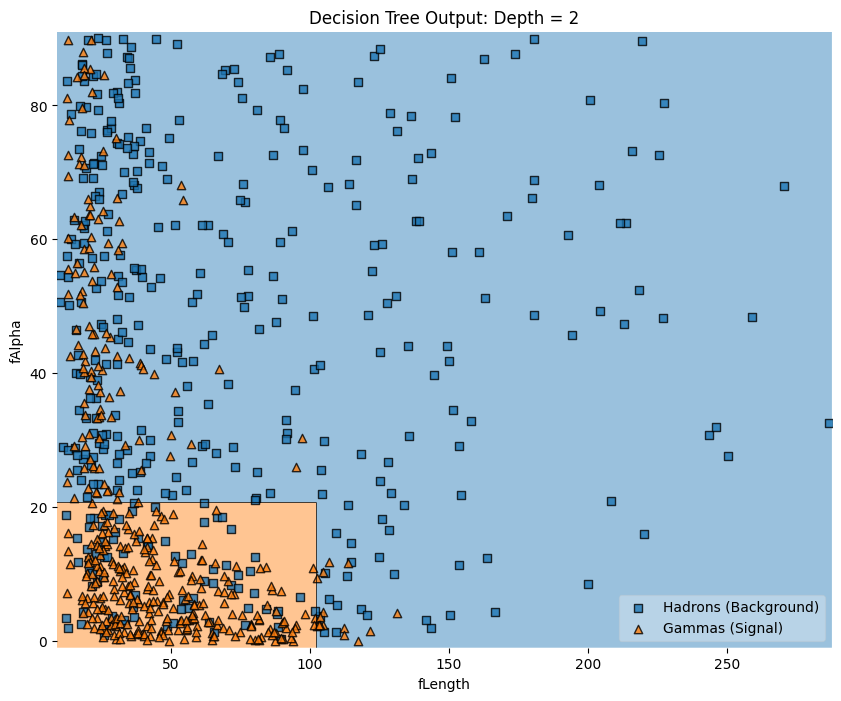

In [28]:
# View our 2 feature depth=2 tree by displaying both
#  our decision regions and a scatter plot of our small test dataset
#  in a 2D plot

fig = plt.figure(figsize=(10, 8))
ax = plot_decision_regions(X=X_test_fLength_fAlpha_small, y=y_test_small, clf=tree_clf_d2, legend=0)
plt.title('Decision Tree Output: Depth = 2')
plt.xlabel('fLength')
plt.ylabel('fAlpha')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          ['Hadrons (Background)', 'Gammas (Signal)'],
           framealpha=0.3, scatterpoints=1)
plt.show()

#### Use graphviz to visualize the tree

The graphviz package will create a very nice image for viewing each branch and leaf of our tree.

First visualize the Depth = 1 tree:

In [29]:
with open("tree_d1.dot", 'w') as f:

  export_graphviz(
    tree_clf_d1,
    out_file=f,
    feature_names=["fLength","fAlpha"],
    class_names=["Background","Signal"],
    rounded=True,
    filled=True
  )

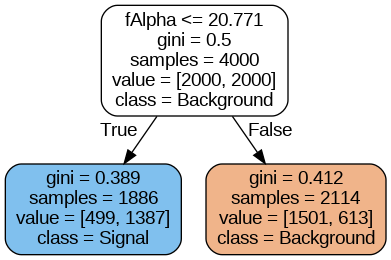

In [30]:
from graphviz import Source

dot_path = "tree_d1.dot"
output = Source.from_file(dot_path, format = "png") # can change png to pdf
output.view()

from IPython.display import Image
Image('tree_d1.dot.png')

Visualize the Depth = 2 tree

In [31]:
with open("tree_d2.dot", 'w') as f:

  export_graphviz(
    tree_clf_d2,
    out_file=f,
    feature_names=["fLength","fAlpha"],
    class_names=["Background","Signal"],
    rounded=True,
    filled=True
  )

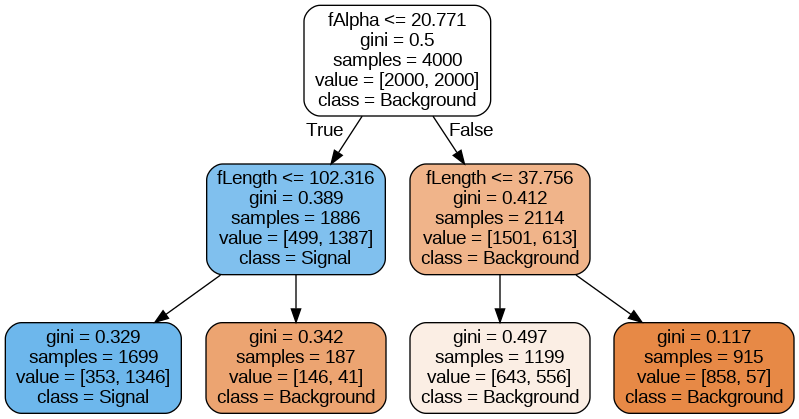

In [32]:
dot_path = "tree_d2.dot"
output = Source.from_file(dot_path, format = "png") # can change png to pdf
output.view()
Image('tree_d2.dot.png')

#### Use sklearn to visualize the tree as text

In [33]:
from sklearn import tree

print("Depth = 1 Tree")
text_representation = tree.export_text(tree_clf_d1)
print(text_representation)

print("Depth = 2 Tree")
text_representation = tree.export_text(tree_clf_d2)
print(text_representation)


Depth = 1 Tree
|--- feature_1 <= 20.77
|   |--- class: 1
|--- feature_1 >  20.77
|   |--- class: 0

Depth = 2 Tree
|--- feature_1 <= 20.77
|   |--- feature_0 <= 102.32
|   |   |--- class: 1
|   |--- feature_0 >  102.32
|   |   |--- class: 0
|--- feature_1 >  20.77
|   |--- feature_0 <= 37.76
|   |   |--- class: 0
|   |--- feature_0 >  37.76
|   |   |--- class: 0



### Make a ROC curve

Finally we can make ROC curves to compare the performance of our tree. We will plot true-postive-rate (TPR, aka signal efficiency) vs false-postive-rate (FPR, aka background mis-ID rate).

scikit-learn has a tool for this:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

y_true ndarray of shape (n_samples,)

    True binary labels. If labels are not either {-1, 1} or {0, 1}, then pos_label should be explicitly given.
    
y_score ndarray of shape (n_samples,)

    Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).



In [34]:
# Create arrays for our ROC curve using built-in tools (metrics.roc_curve)
#   Feed this tool the truth information and the leaf probabiliites

fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test.astype(bool), tree_clf_d1_proba)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test.astype(bool), tree_clf_d2_proba)

In [35]:
print("fpr1        =",fpr1)
print("tpr1        =",tpr1)
print("thresholds1 =",thresholds1)
print("fpr2        =",fpr2)
print("tpr2        =",tpr2)
print("thresholds1 =",thresholds2)

fpr1        = [0.         0.24210751 1.        ]
tpr1        = [0.         0.69967093 1.        ]
thresholds1 = [1.73541888 0.73541888 0.28997162]
fpr2        = [0.         0.18003413 0.5121587  0.57423208 1.        ]
tpr2        = [0.         0.67315137 0.94086334 0.96738289 1.        ]
thresholds1 = [1.79223072 0.79223072 0.46371977 0.21925134 0.06229508]


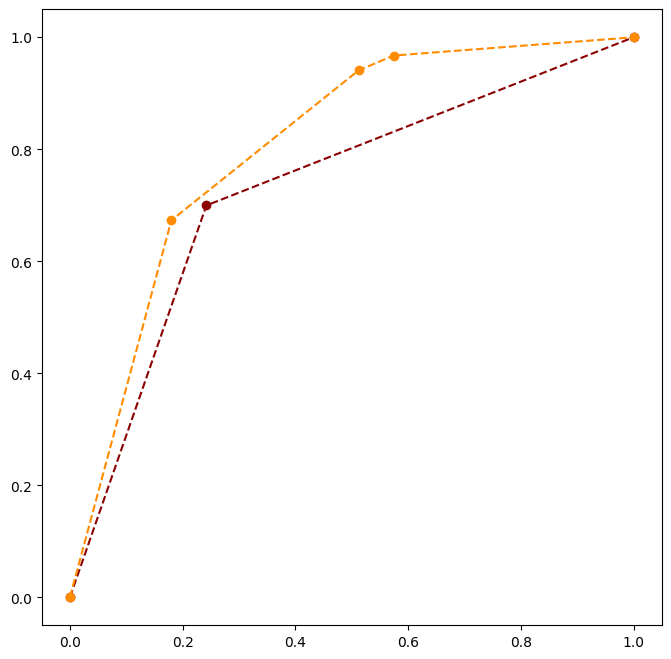

In [36]:
# Quick look:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(fpr1, tpr1, "o--", color='darkred',label="2 Feature Decision Tree - Depth = 1")
plt.plot(fpr2, tpr2,"o--", color='darkorange',label="2 Feature Decision Tree - Depth = 2")

Borrow some code from project 1 to create a ROC curve using only fAlpha. This will serve as a comparision (we can compare the decision tree to a simple 1D cut).


In [37]:

def make_ROC_arrays(my_feature_name, ge, low, high, verbose ):

  cuts = np.linspace(low,high,101)
  le_cut =  9999999
  ge_cut = -9999999
  # Create lists to contain the number of events passing a given cut
  effic  = []
  mistag = []
  list_cuts = []

  for cut in cuts:

    if ge:
      ge_cut = cut
      le_cut = high
    else:
      ge_cut = low
      le_cut = cut


    s_num = df_gammas[ (df_gammas[my_feature_name]>= ge_cut) & (df_gammas[my_feature_name]<= le_cut)][my_feature_name].count()
    s_den = df_gammas[my_feature_name].count()
    s_eff = s_num/s_den

    b_num = df_hadrons[ (df_hadrons[my_feature_name]>= ge_cut) & (df_hadrons[my_feature_name]<= le_cut)][my_feature_name].count()
    b_den = df_hadrons[my_feature_name].count()
    b_eff = b_num/b_den

    effic.append(s_eff)
    mistag.append(b_eff)
    list_cuts.append(cut)

    if(verbose):
       print(ge_cut,"<= ",my_feature_name," <=", le_cut, "s_eff",s_eff,"b_eff",b_eff)

  a_effic  = np.array(effic)
  a_mistag = np.array(mistag)
  a_cuts = np.array(list_cuts)

  return a_effic, a_mistag, a_cuts


In [38]:
a_eff_s_fAlpha   , a_eff_b_fAlpha, a_cuts_fAlpha   = make_ROC_arrays("fAlpha"   , False, 0,100, False)


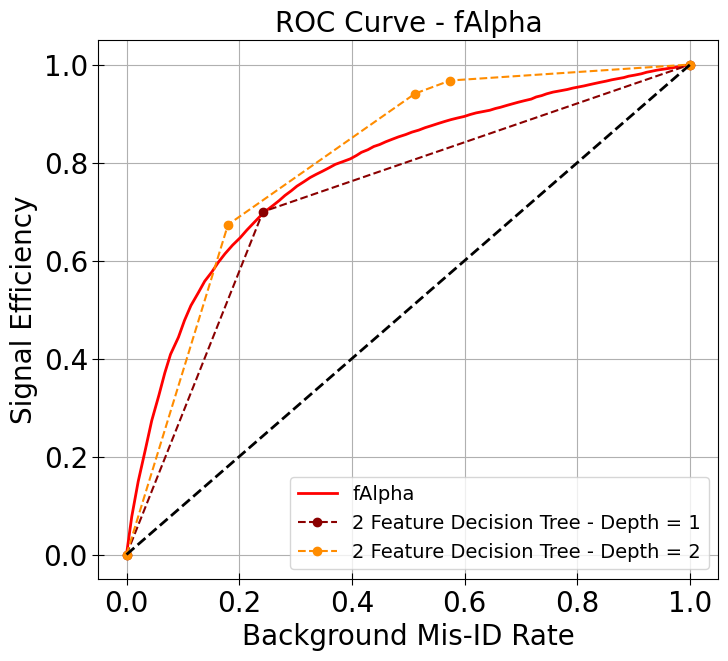

In [39]:

fig, ax = plt.subplots(figsize=(8, 7))

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

ax.plot(a_eff_b_fAlpha   , a_eff_s_fAlpha   , "-", linewidth=2, label='fAlpha',  color='Red')


plt.plot(fpr1, tpr1,"o--", color='darkred',label="2 Feature Decision Tree - Depth = 1")
plt.plot(fpr2, tpr2, "o--",color='darkorange',label="2 Feature Decision Tree - Depth = 2")

ax.set_ylabel("Signal Efficiency" ,  fontsize=20)
ax.set_xlabel("Background Mis-ID Rate" , fontsize=20)
ax.set_title('ROC Curve - fAlpha',  fontsize=20)

ax.tick_params(axis='both', which='major', length=8, labelsize=20,  direction = "inout")

# Draw a grid
ax.grid(True,which='major', axis='both')

# Draw a line to represent breaking even (no classification advantage)
x = [0,1]
y = [0,1]
ax.plot(x, y,linestyle='dashed', linewidth=2, color = "Black")

# Draw a legend
plt.legend(loc='lower right', prop={'size': 14})

fig.show()

## Exercise 1: Create a depth-1 decision tree "by hand"

### Caculating Gini impurity and cost function


#### Introduction

Recall the Gini impurity equation:

$G_i = 1 - \sum_{j=1}^n p_{i,j}^2$

Here $i$ is the node, $j$ is the class, and $p$ = (number of given class in node $i$)/(total number in node $i$).

In this case we only have two classes (signal gammas and background hadrons) so the sum simplifies to be:

$G_{i} = 1 - \Big( \frac{N_{g-i}}{N_{i}}\Big)^2 - \Big(\frac{N_{h-i}}{N_{i}}\Big)^2$

If we select a given feature and threshold, there will be events that are less than the threshold (left of the threshold = our left node) and events that are greater than the threshold (right of the threshold = our right node). This allows us to calculate Gini left and Gini right:

$G_{left} = 1 - \Big(\frac{N_{g-left}}{N_{left}}\Big)^2 - \Big(\frac{N_{h-left}}{N_{left}}\Big)^2$

$G_{right} = 1 - \Big(\frac{N_{g-right}}{N_{right}}\Big)^2 - \Big(\frac{N_{h-right}}{N_{right}}\Big)^2$

The cost function is defined to be:

$J(k,t_k) = \frac{N_{left}}{N_{total}}G_{left}+\frac{N_{right}}{N_{total}}G_{right}$



#### Exercise 1.1

Choose the 'fAlpha' feature from the MAGIC data. Choose the 'fAlpha' threshold that you picked "by eye" in Project 1. Given that feature and that threshold, use the training dataset to calculate and report Gini Left, Gini Right, and the Cost Function.

In [40]:
# Some example code to get you started

my_feature_name = "fAlpha"
cut = 20.771

# Find the total number of events in the training dataset
n_total =  df_all_train[my_feature_name].count()

# Find the number of events in the training set which are in the left node
n_left = df_all_train[ df_all_train[my_feature_name]<= cut][my_feature_name].count()

# Find the number of events in the training set which are in the left node and are signal gammas
n_left_sig = df_all_train[ (df_all_train[my_feature_name]<= cut) & (df_all_train["isGamma"]==True)][my_feature_name].count()

# Find the number of events in the training set which are in the left node and are background hadrons
n_left_bkg = df_all_train[ (df_all_train[my_feature_name]<= cut) & (df_all_train["isGamma"]==False)][my_feature_name].count()

# Find the number of events in the training set which are in the right node
n_right = df_all_train[ df_all_train[my_feature_name]> cut][my_feature_name].count()

# Find the number of events in the training set which are in the right node and are signal gammas
n_right_sig = df_all_train[ (df_all_train[my_feature_name]> cut) & (df_all_train["isGamma"]==True)][my_feature_name].count()

# Find the number of events in the training set which are in the right node and are background hadrons
n_right_bkg = df_all_train[ (df_all_train[my_feature_name]> cut) & (df_all_train["isGamma"]==False)][my_feature_name].count()


print(n_left_sig,n_left_bkg,n_left_sig+n_left_bkg,n_left)

1387 499 1886 1886


#### Exercise 1.2

*   Select the same feature you selected above (fAlpha)
*   Vary the theshold between some minimum and maximum value.
*   For each threshold, calculate Gini Left, Gini Right, and the Cost Function.
*   Use an if statement to determine which threshold produces the minimum cost function
*   Track each value of the treshold and cost function using a list. Plot Cost Funciton vs Treshold.
*   Is the threshold you found which minimizes the cost funciton similar to threshold found in the Scikit-Learn example above?




In [41]:
# Some example code to get you started

# Create an array of 200 thesholds between 0 and 100
low = 0
high = 100
thresholds = np.linspace(low,high,200)

# Define a variable which records the minimum cost function
minimum_cost_function = 99999

# Iterate over all thresholds
for cut in thresholds:
  # Calculate gini left, gini right, cost function
  cost_function = 9999 # Replace with your calculation (similar to part 1.1)

  # Track the minimum cost function
  if cost_function < minimum_cost_function:
    minimum_cost_function = cost_function

# Report results
print("Minimum cost funciton =",minimum_cost_function)

Minimum cost funciton = 9999


## Exercise 2: Decision Tree Depth Exploration

Now that we have created a decision tree "by hand" and we know how they grow, we can go back to using scikit-Learn.


*   Using the same 2 variables defined in the example above, create trees with max_depth=3 and max_depth=4.

*   For each tree plot scatter the plot with decisions regions.

*   For each tree use graphviz to visualize the tree.

*   Recreate the ROC curve plot from the example above and add these trees.

## Exercise 3 - Increase the number of features




*   Create a 5 feature training dataset and testing dataset
*   Grow two trees: Depth =2 and Depth = 4
*   Get the outputs from each classifier
*   Visualize each tree graphically using graphviz
*   Make a plot with the ROC curve for each tree and for fAlpha (grab this from the example above for a reference).







#### Training setup

#### Testing setup

#### Create and fit the decision **tree**



### Get the outputs of the classifiers

### Visualize